# House Rent Prediction - Análise Exploratória de Dados e Pré-Processamento

## Importe do Dataset e Blibliotecas

In [204]:
# Utilities
import numpy as np
import pandas as pd
import math

# Matplotlib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns

# Scipy
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# SKLearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization

# Dataset
import kagglehub
path = kagglehub.dataset_download("iamsouravbanerjee/house-rent-prediction-dataset")
dataset = pd.read_csv(f"{path}\\House_Rent_Dataset.csv")

# Definição da Seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## Análise Exploratória de Dados

### Visão geral dos dados

In [205]:
# Verificando quantas colunas e linhas o dataset possui
dataset.shape

(4746, 12)

In [206]:
# 5 primeiras linhas para entendermos os dados
dataset.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [207]:
# Informações das colunas
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [208]:
# Posted On está como objeto então vamos transformar para o tipo de dado correto
dataset['Posted On'] = pd.to_datetime(dataset['Posted On'])

In [209]:
# Checagem por valores nulos
dataset.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [210]:
# Distribuição das colunas
dataset.describe()

,Posted On,BHK,Rent,Size,Bathroom
count,4746,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2022-06-07 18:01:40.126422272,2.083860,3.499345e+04,967.490729,1.965866
min,2022-04-13 00:00:00,1.000000,1.200000e+03,10.000000,1.000000
25%,2022-05-20 00:00:00,2.000000,1.000000e+04,550.000000,1.000000
50%,2022-06-10 00:00:00,2.000000,1.600000e+04,850.000000,2.000000
75%,2022-06-28 00:00:00,3.000000,3.300000e+04,1200.000000,2.000000
max,2022-07-11 00:00:00,6.000000,3.500000e+06,8000.000000,10.000000
std,NaN,0.832256,7.810641e+04,634.202328,0.884532


### Gráficos

#### Distribuição da coluna target (Rent)

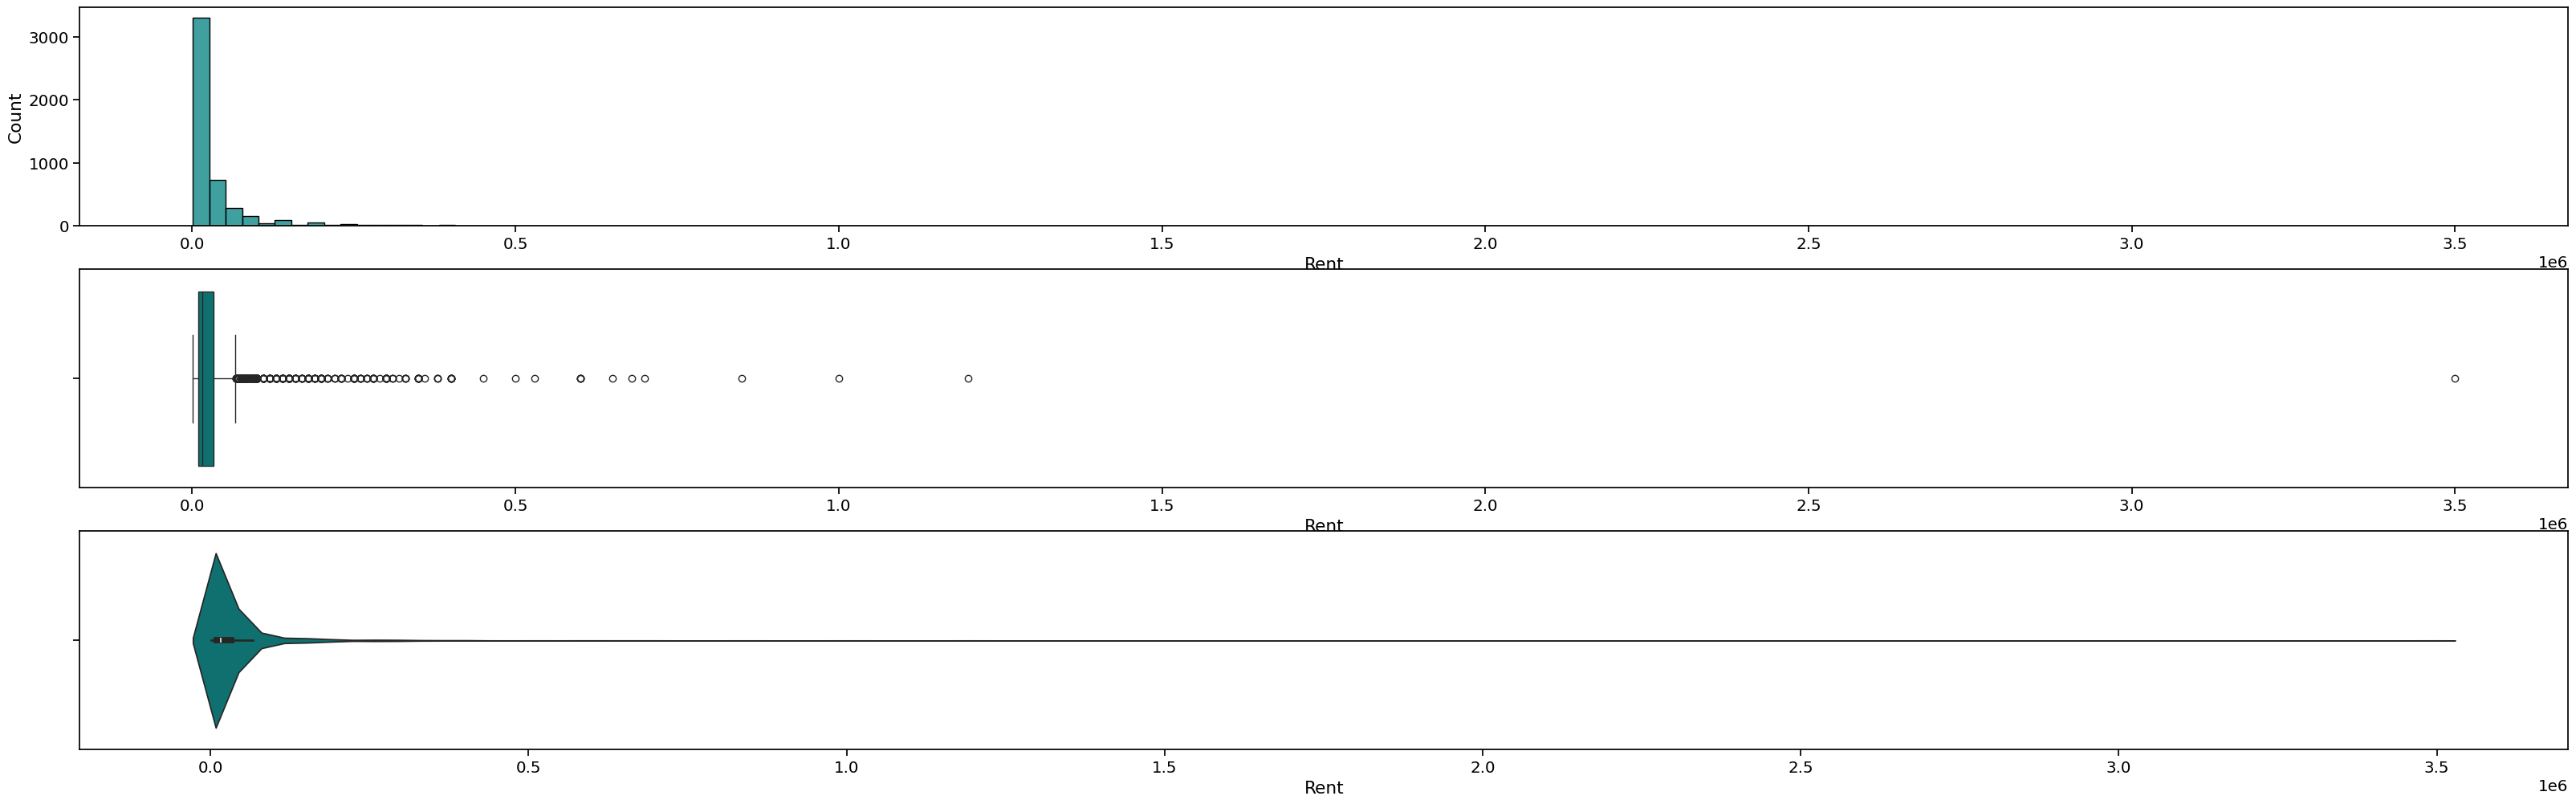

'\nComentários:\n\nPode-se perceber que o dataset possui outliers bem presentes nos valores maiores de aluguéis,\nimplicando em uma distribuição altamente assimétrica com obliquidade positiva.\nNo final, isso gera um modelo enviesado e sem a capacidade de generalização.\n\n'

In [211]:
# Rent - em Rúpias Indianas (INR)

fig, ax = plt.subplots(3, 1, figsize=(40, 12))
ax1 = sns.histplot(x = dataset['Rent'], color ='teal', ax = ax[0])
ax2 = sns.boxplot(x = dataset['Rent'], color = 'teal', ax = ax[1])
ax3 = sns.violinplot(x = dataset['Rent'], color = 'teal', ax = ax[2])
plt.show()

"""
Comentários:

Pode-se perceber que o dataset possui outliers bem presentes nos valores maiores de aluguéis,
implicando em uma distribuição altamente assimétrica com obliquidade positiva.
No final, isso gera um modelo enviesado e sem a capacidade de generalização.

"""

In [212]:
# Identificando os outliers
Q1 = dataset['Rent'].quantile(0.25)
Q3 = dataset['Rent'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = dataset[(dataset['Rent'] < limite_inferior) | (dataset['Rent'] > limite_superior)]
print(f"Número de outliers presente no dataset: {len(outliers)}")

Número de outliers presente no dataset: 520


#### Distribuição da coluna Size

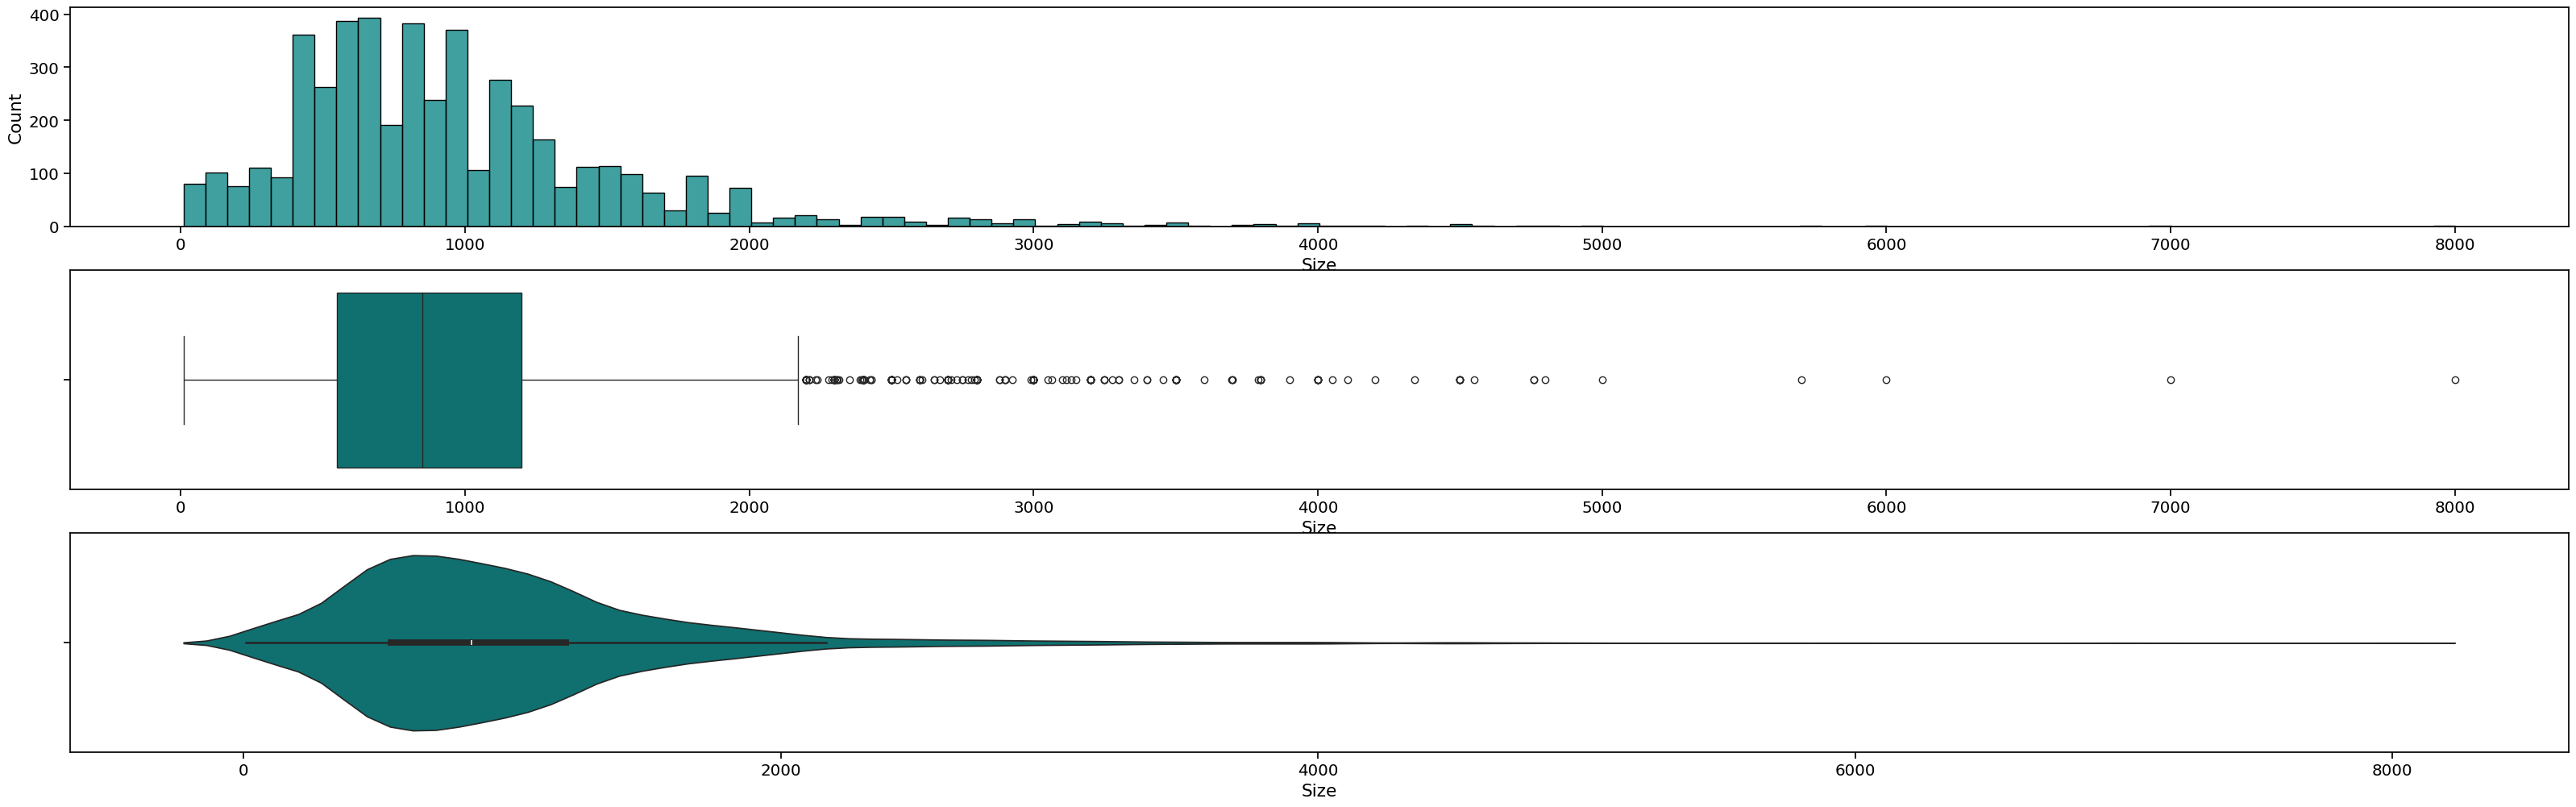

'\n\nComentários:\nEssa coluna possui outliers em valores muito altos também. Assim como na coluna de Rent.\nSua distribuição está relativamente assimétrica e com obliquidade positiva.\n\n'

In [213]:
# Size

fig, ax = plt.subplots(3, 1, figsize=(40, 12))
ax1 = sns.histplot(x = dataset['Size'], color='teal', ax= ax[0])
ax2 = sns.boxplot(x = dataset['Size'], ax= ax[1], color= 'teal')
ax3 = sns.violinplot(x = dataset['Size'], ax= ax[2], color= 'teal')
plt.show()

"""

Comentários:
Essa coluna possui outliers em valores muito altos também. Assim como na coluna de Rent.
Sua distribuição está relativamente assimétrica e com obliquidade positiva.

"""

#### Relação Colunas Numéricas e Rent

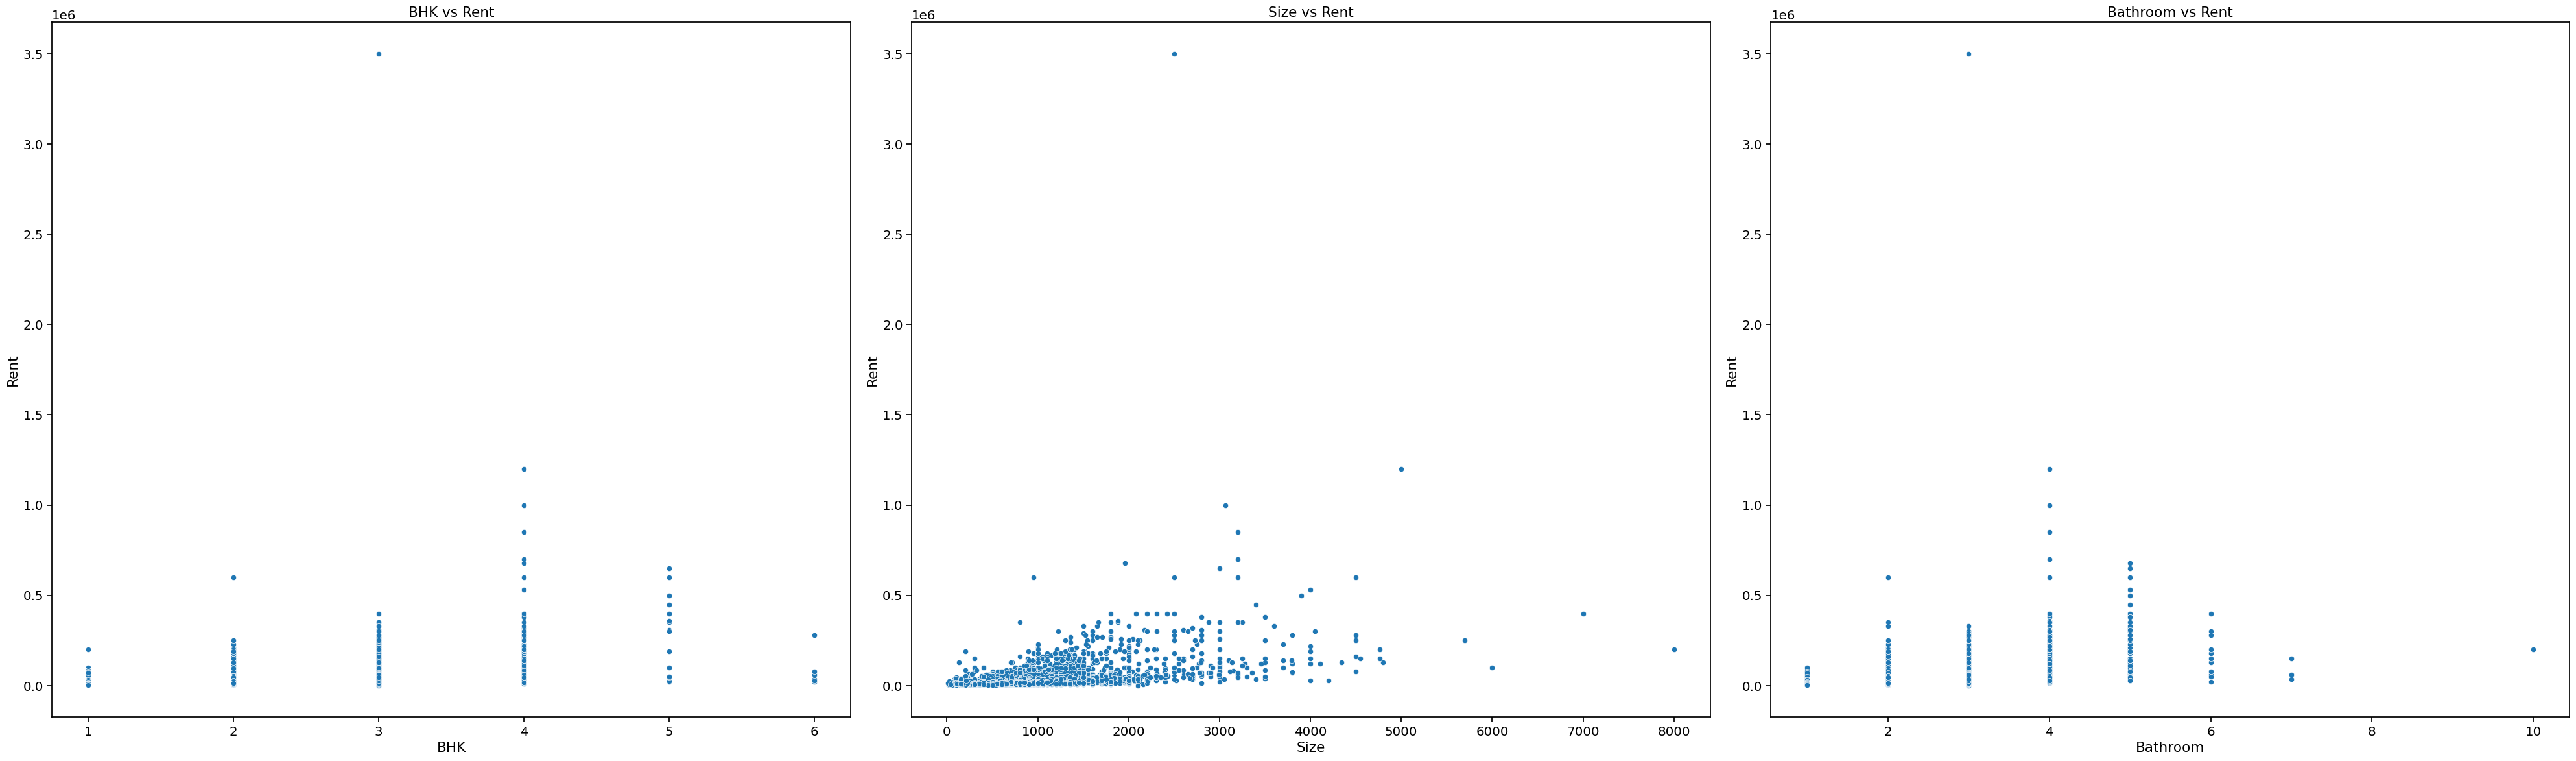

'\nComentários:\n\n1. Em geral o aluguel tende a aumentar de acordo com o número de cômodos mas há bastante dipersão. \nIsso indica que essa medida sozinha não explica muito o valor do aluguel.\n\n2. Apesar dos outliers e algumas dispersões essa variável é a que apresenta maior correlação com o valor do aluguel.\n\n3. Mesma questão do número de cômodos, quando maior o número de banheiros maior o aluguel, mas apresenta muita dispersão.\nMas ela sozinha não explica muito o valor do aluguel.\n\n'

In [214]:
numericas = ['BHK', 'Size', 'Bathroom']

fig, ax = plt.subplots(1, 3, figsize=(40, 12))

for i, col in enumerate(numericas):
    sns.scatterplot(x=col, y='Rent', data=dataset, ax=ax[i])
    ax[i].set_title(f"{col} vs Rent")

plt.tight_layout()
plt.show()

"""
Comentários:

1. Em geral o aluguel tende a aumentar de acordo com o número de cômodos mas há bastante dipersão. 
Isso indica que essa medida sozinha não explica muito o valor do aluguel.

2. Apesar dos outliers e algumas dispersões essa variável é a que apresenta maior correlação com o valor do aluguel.

3. Mesma questão do número de cômodos, quando maior o número de banheiros maior o aluguel, mas apresenta muita dispersão.
Mas ela sozinha não explica muito o valor do aluguel.

"""

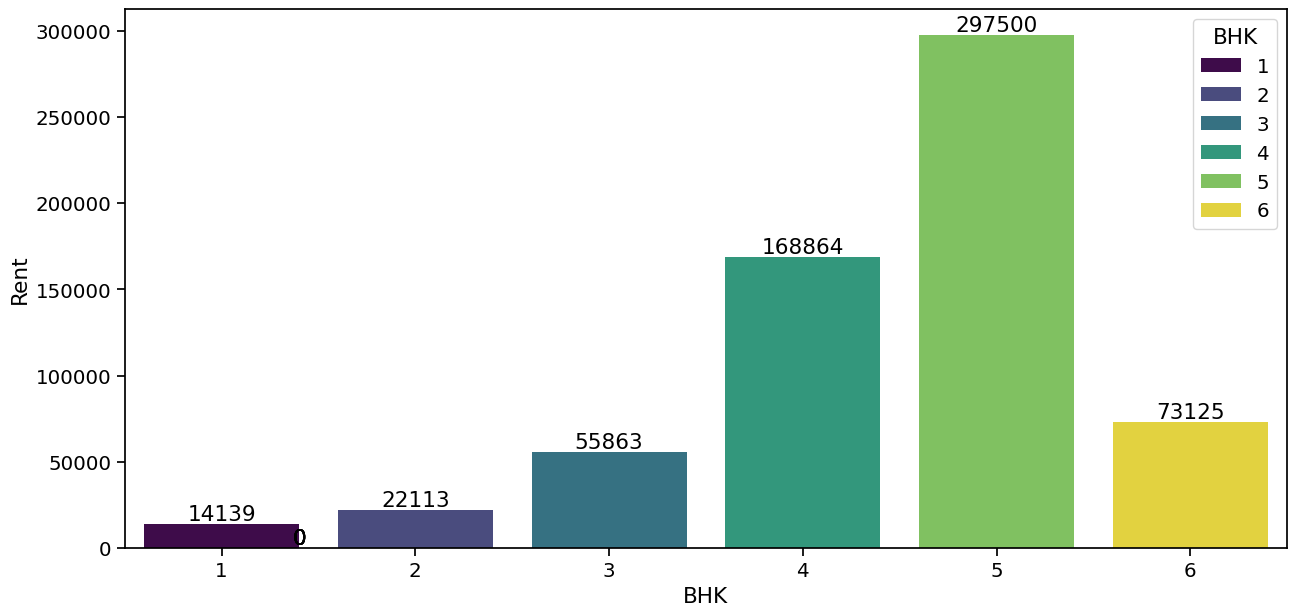

In [215]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 7))
ax = sns.barplot(x=dataset['BHK'].sort_values(ascending=True), 
                 y=dataset['Rent'], 
                 palette='viridis',
                 hue=dataset['BHK'],
                 errorbar=None)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

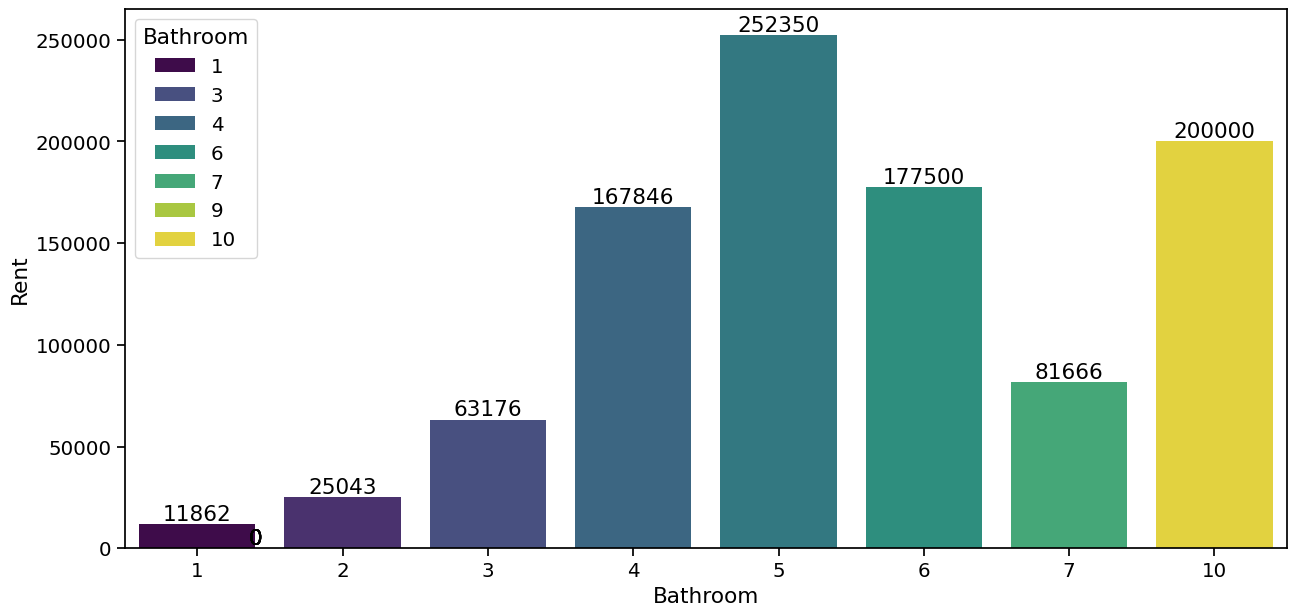

In [216]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 7))
ax = sns.barplot(x=dataset['Bathroom'],
                 y=dataset['Rent'], 
                 palette='viridis',
                 hue=dataset['Bathroom'],
                 errorbar=None)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

#### Relação Colunas Categóricas e Rent

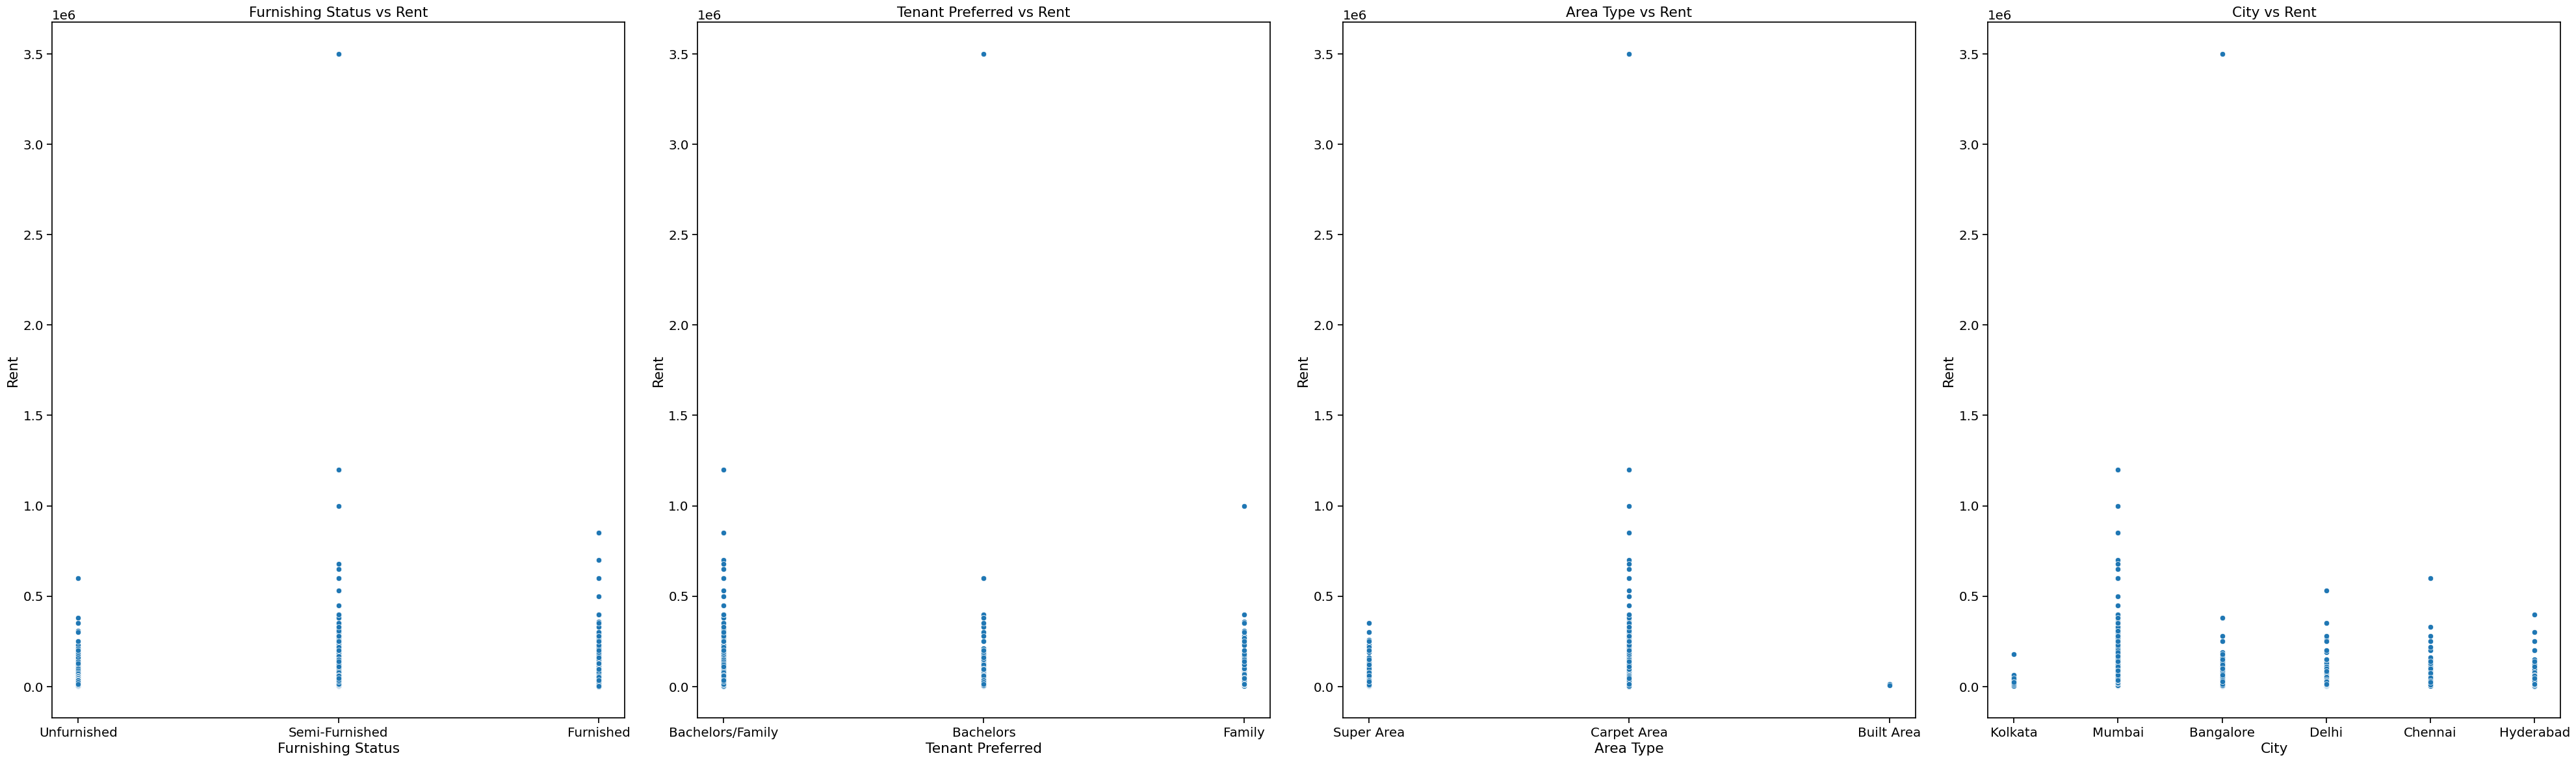

"\nComentários:\n\n1. Imóveis semi-mobiliados ('Semi-Furnished') e mobiliados ('Furnished') apresentam os aluguéis mais caros. Imóveis não mobiliados ('Unfurnished') parecem ter um teto de valor significativamente mais baixo.\n\n2. A categoria 'Bachelors/Family' (Solteiros/Família) concentra quase todos os aluguéis de valores extremos (altos e baixos), tornando esta variável pouco preditiva sozinha. As outras categorias ('Bachelors', 'Family') se limitam a valores mais baixos.\n\n2. Quase todos os imóveis com aluguéis mais altos estão na categoria 'Carpet Area'. Os tipos 'Super Area' e 'Built Area' concentram-se estritamente em valores mais baixos.\n\n3. A cidade é um fator crucial. Mumbai se destaca com os aluguéis mais caros e a maior dispersão de valores, seguida por Bangalore e Delhi. As outras cidades analisadas (Kolkata, Chennai, Hyderabad) possuem valores consideravelmente menores.\n"

In [217]:
categoricas = ['Furnishing Status', 'Tenant Preferred', 'Area Type', 'City']

fig, ax = plt.subplots(1, 4, figsize=(40, 12))

for i, col in enumerate(categoricas):
    sns.scatterplot(x=col, y='Rent', data=dataset, ax=ax[i])
    ax[i].set_title(f"{col} vs Rent")

plt.tight_layout()
plt.show()

"""
Comentários:

1. Imóveis semi-mobiliados ('Semi-Furnished') e mobiliados ('Furnished') apresentam os aluguéis mais caros. Imóveis não mobiliados ('Unfurnished') parecem ter um teto de valor significativamente mais baixo.

2. A categoria 'Bachelors/Family' (Solteiros/Família) concentra quase todos os aluguéis de valores extremos (altos e baixos), tornando esta variável pouco preditiva sozinha. As outras categorias ('Bachelors', 'Family') se limitam a valores mais baixos.

2. Quase todos os imóveis com aluguéis mais altos estão na categoria 'Carpet Area'. Os tipos 'Super Area' e 'Built Area' concentram-se estritamente em valores mais baixos.

3. A cidade é um fator crucial. Mumbai se destaca com os aluguéis mais caros e a maior dispersão de valores, seguida por Bangalore e Delhi. As outras cidades analisadas (Kolkata, Chennai, Hyderabad) possuem valores consideravelmente menores.
"""


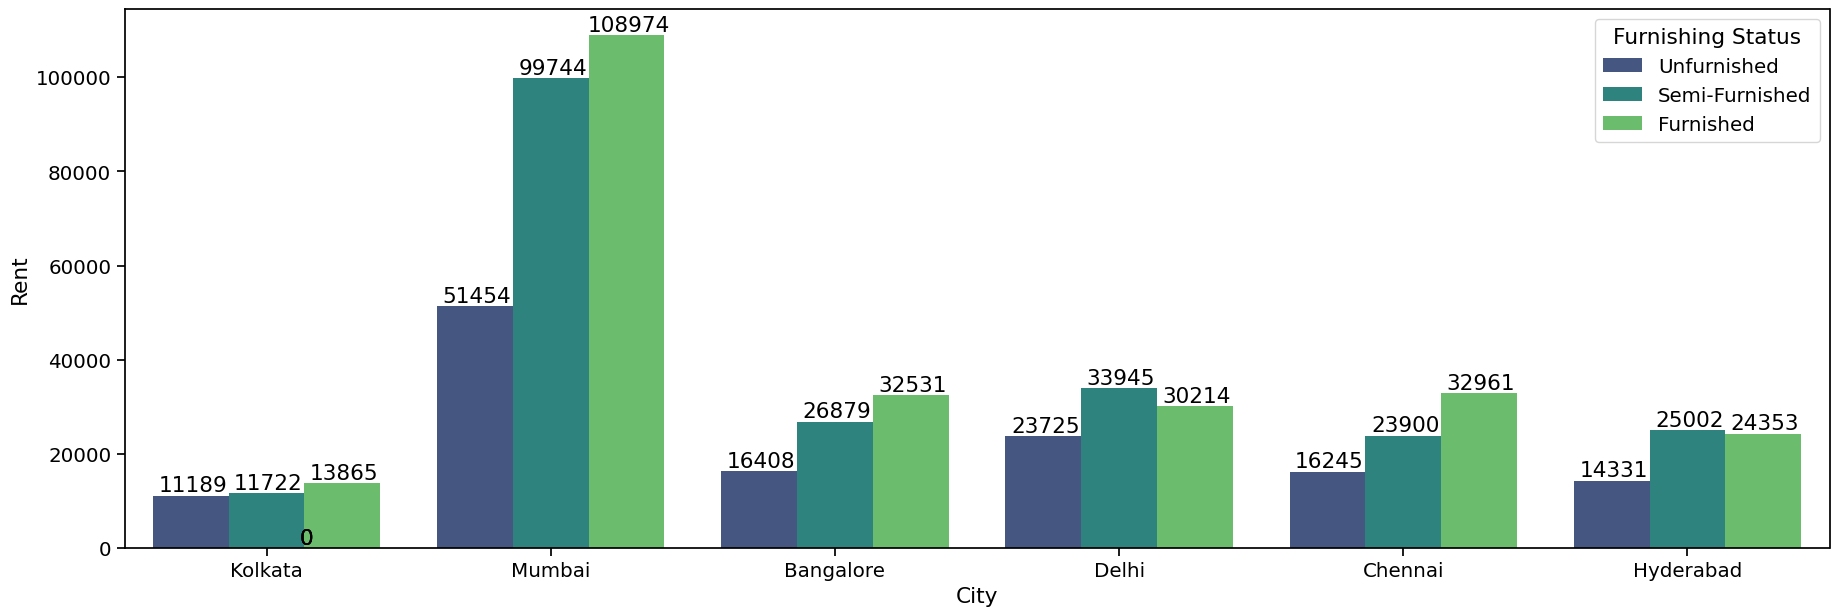

In [218]:
# Furnishing Status
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=dataset['City'], 
                 y=dataset['Rent'],
                 hue = dataset['Furnishing Status'], 
                 palette='viridis',
                 errorbar = None)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.14, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

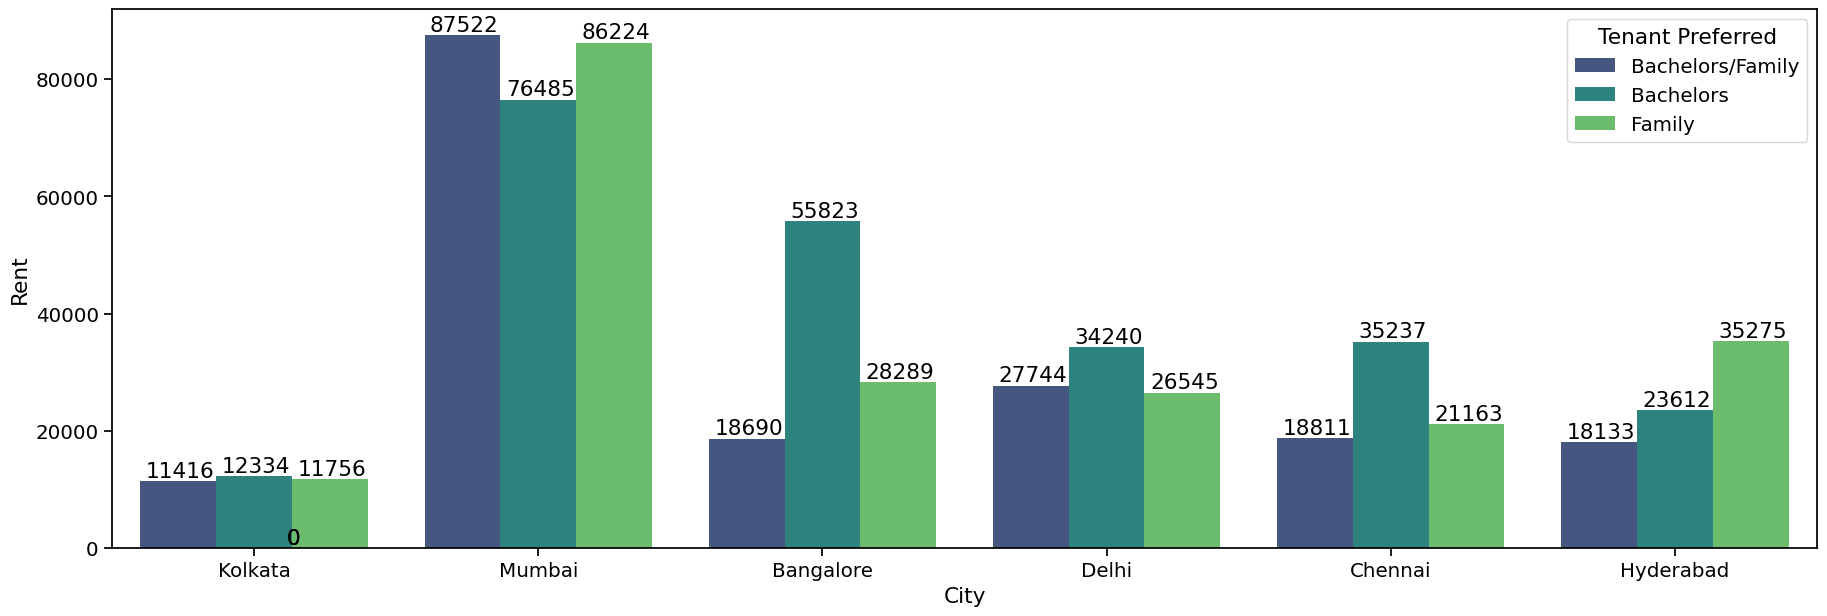

In [219]:
# Tenant Preferred
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=dataset['City'], 
                 y=dataset['Rent'],
                 hue = dataset['Tenant Preferred'], 
                 palette='viridis',
                 errorbar = None)
plt.ylabel('Rent')
 
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.14, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

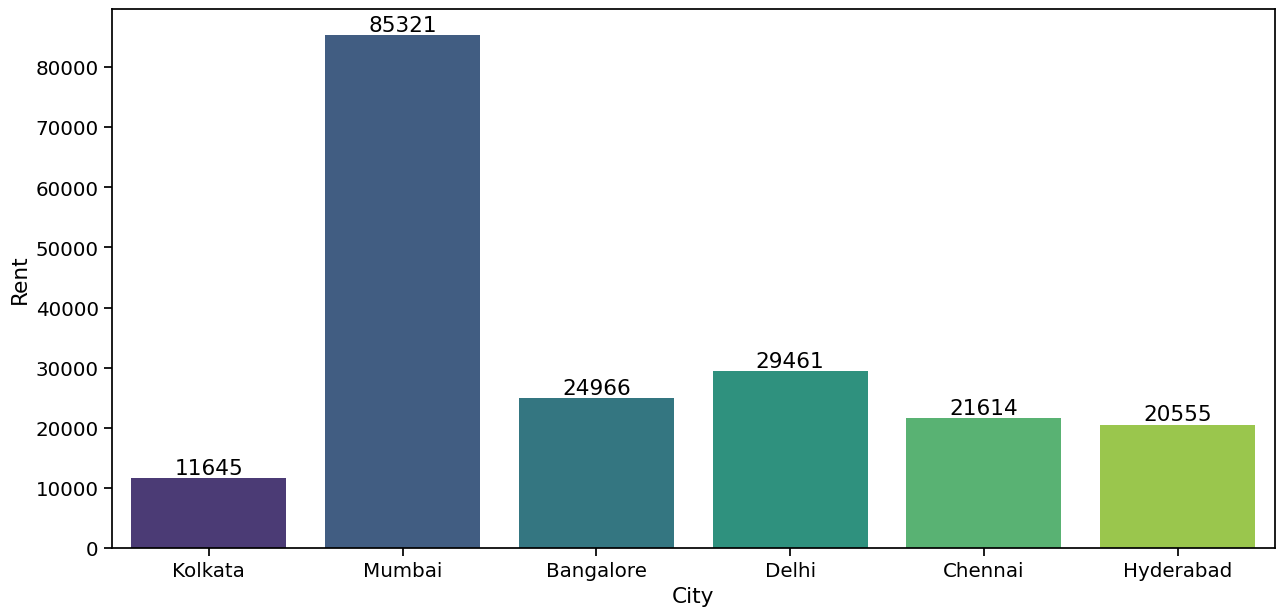

In [220]:
# City
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 7))
ax = sns.barplot(x=dataset['City'], 
                 y=dataset['Rent'], 
                 palette='viridis',
                 hue=dataset['City'],
                 errorbar=None)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')



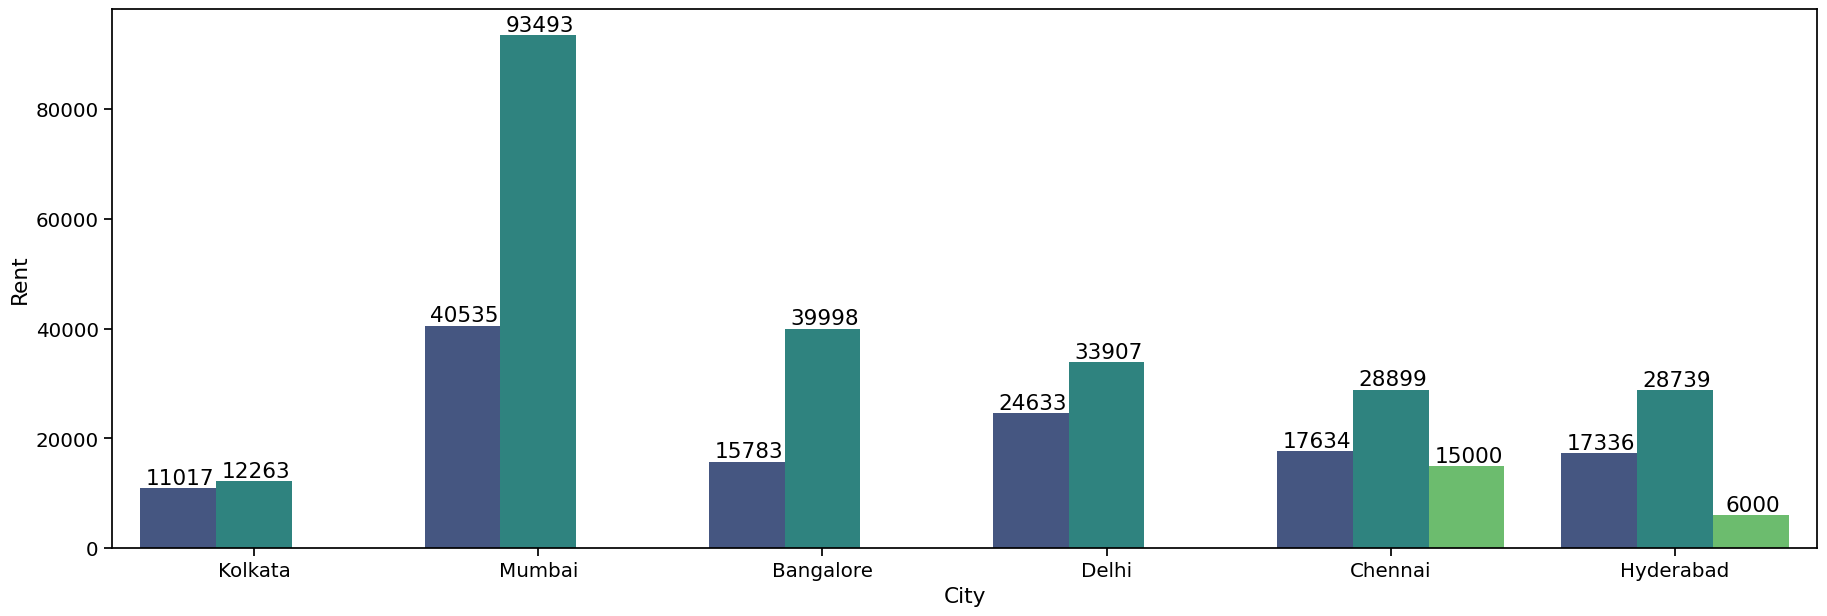

In [221]:
# Area Type
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=dataset['City'], 
                 y=dataset['Rent'],
                 hue = dataset['Area Type'], 
                 palette='viridis',
                 legend = False,
                 errorbar = None)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.14, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

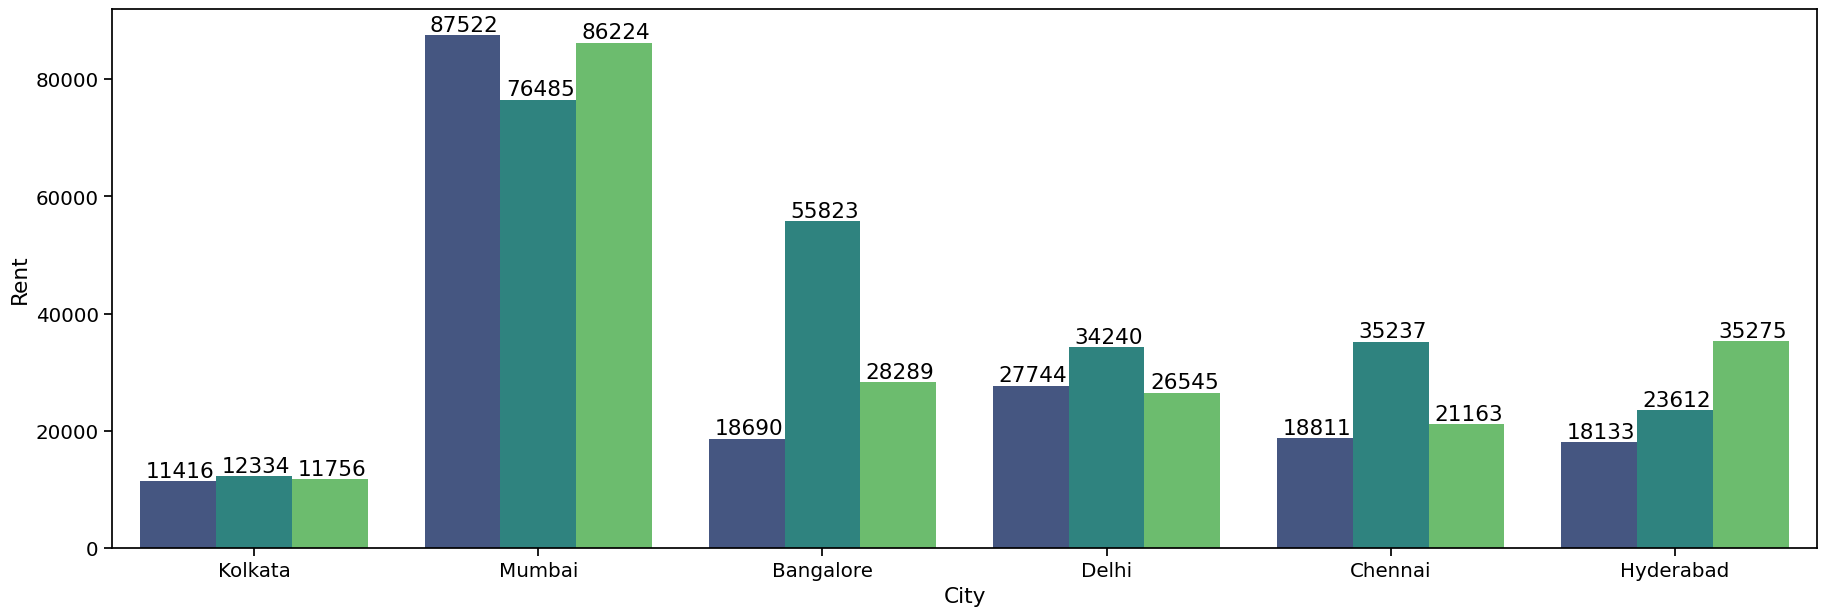

In [222]:
# Tenant Preferred

sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(22, 7))
ax = sns.barplot(x=dataset['City'], 
                 y=dataset['Rent'],
                 hue = dataset['Tenant Preferred'], 
                 palette='viridis',
                 legend = False,
                 errorbar = None)
plt.ylabel('Rent')

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.14, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

#### Matriz de correlação

In [223]:
# fig=px.imshow(df.corr(),text_auto=True, template='plotly_dark', color_continuous_scale=px.colors.sequential.Blues, aspect='auto',title='<b>Correlation matrix')
# fig.update_layout(title_x=0.5)
# fig.show()

## Pré Processamento

### Remoção de Colunas

In [224]:
"""
Baseado nas nossas análises identificamos que algumas colunas 
não possuem uma correlação tão grande com a coluna alvo
"""

dataset = dataset.drop(['Area Locality', 'Posted On'], axis=1)
dataset.head()

,BHK,Rent,Size,Floor,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2,10000,1100,Ground out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2,20000,800,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2,17000,1000,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2,10000,800,1 out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2,7500,850,1 out of 2,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner


### Normalização de Colunas

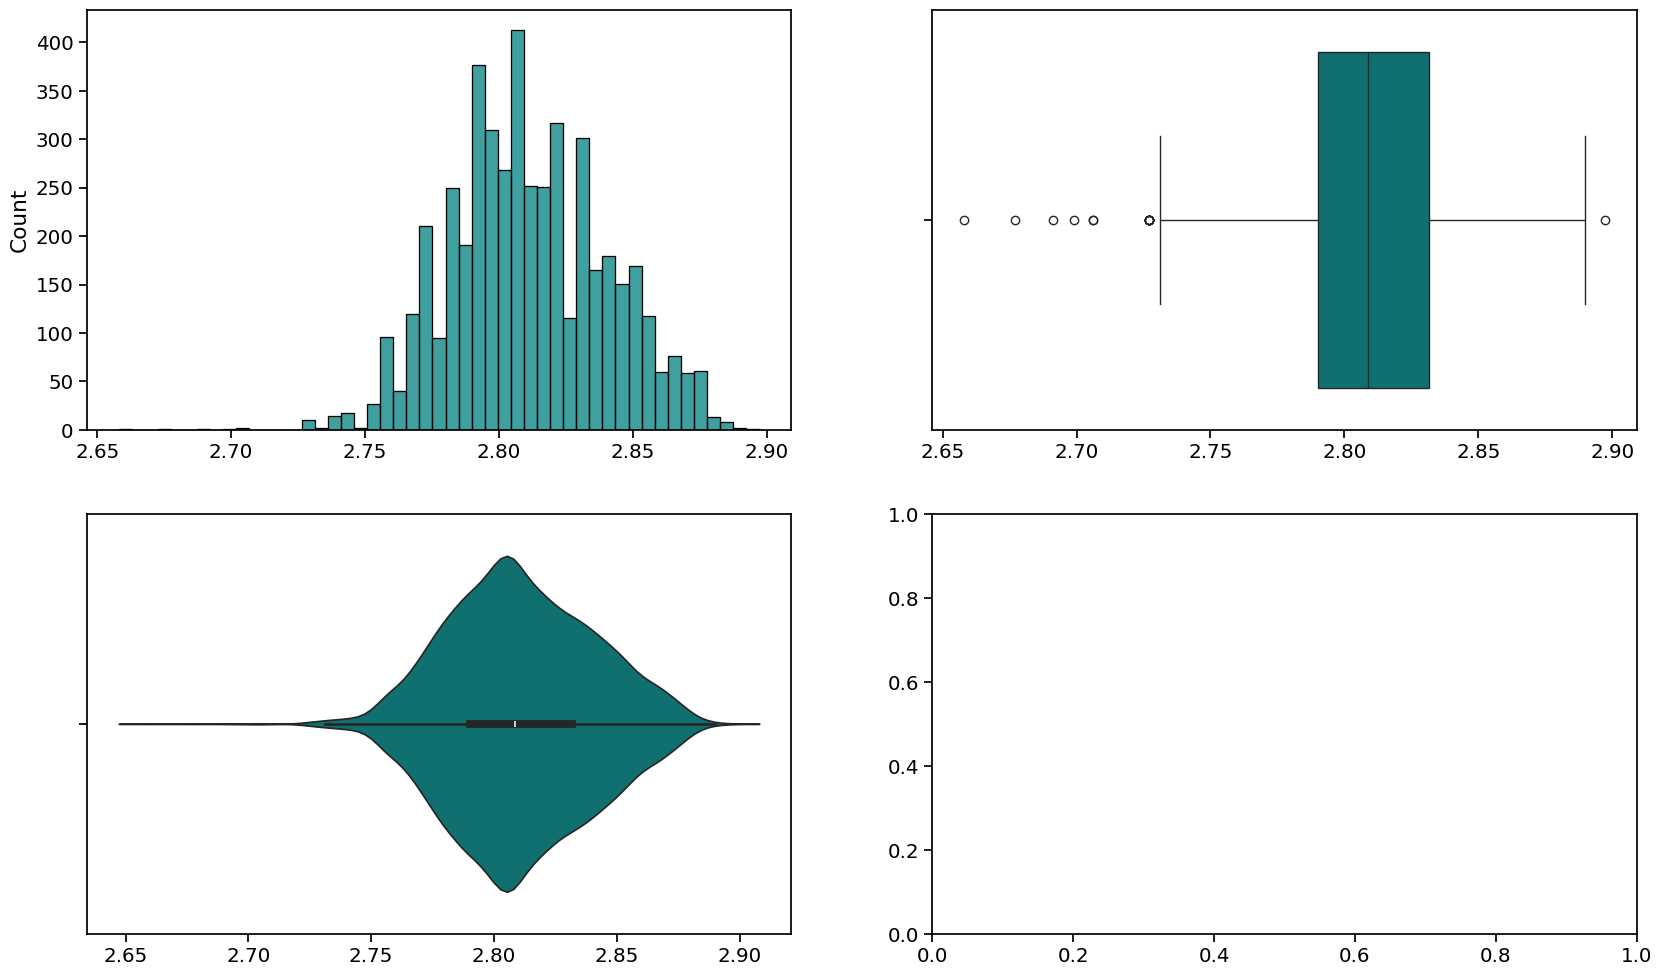

In [225]:
"""
Percebemos que a coluna alvo tem outliers que precisam ser trabalhados.
Além disso, a distribuição dos dados não está tão agradável para regressão
Muita variância pode tornar mais difícil de encontrar padrões nos dados.
"""

max_rent = dataset['Rent'].max()
index_max_rent = dataset[dataset['Rent'] == max_rent].index
data = dataset.drop(index_max_rent)

"""
Para normalizar a coluna vamos utilizar a Box Cox.
A Box Cox é uma técnica de normalização para normalizar variáveis 
idependentes que não são normalmente  distribuídas. 
"""
boxcox_rent, lambda_rent = boxcox(dataset['Rent'])

# Resultados da aplicação das técnicas
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = boxcox_rent, color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = boxcox_rent, ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = boxcox_rent, ax= ax[1, 0], color= 'teal')

plt.show()

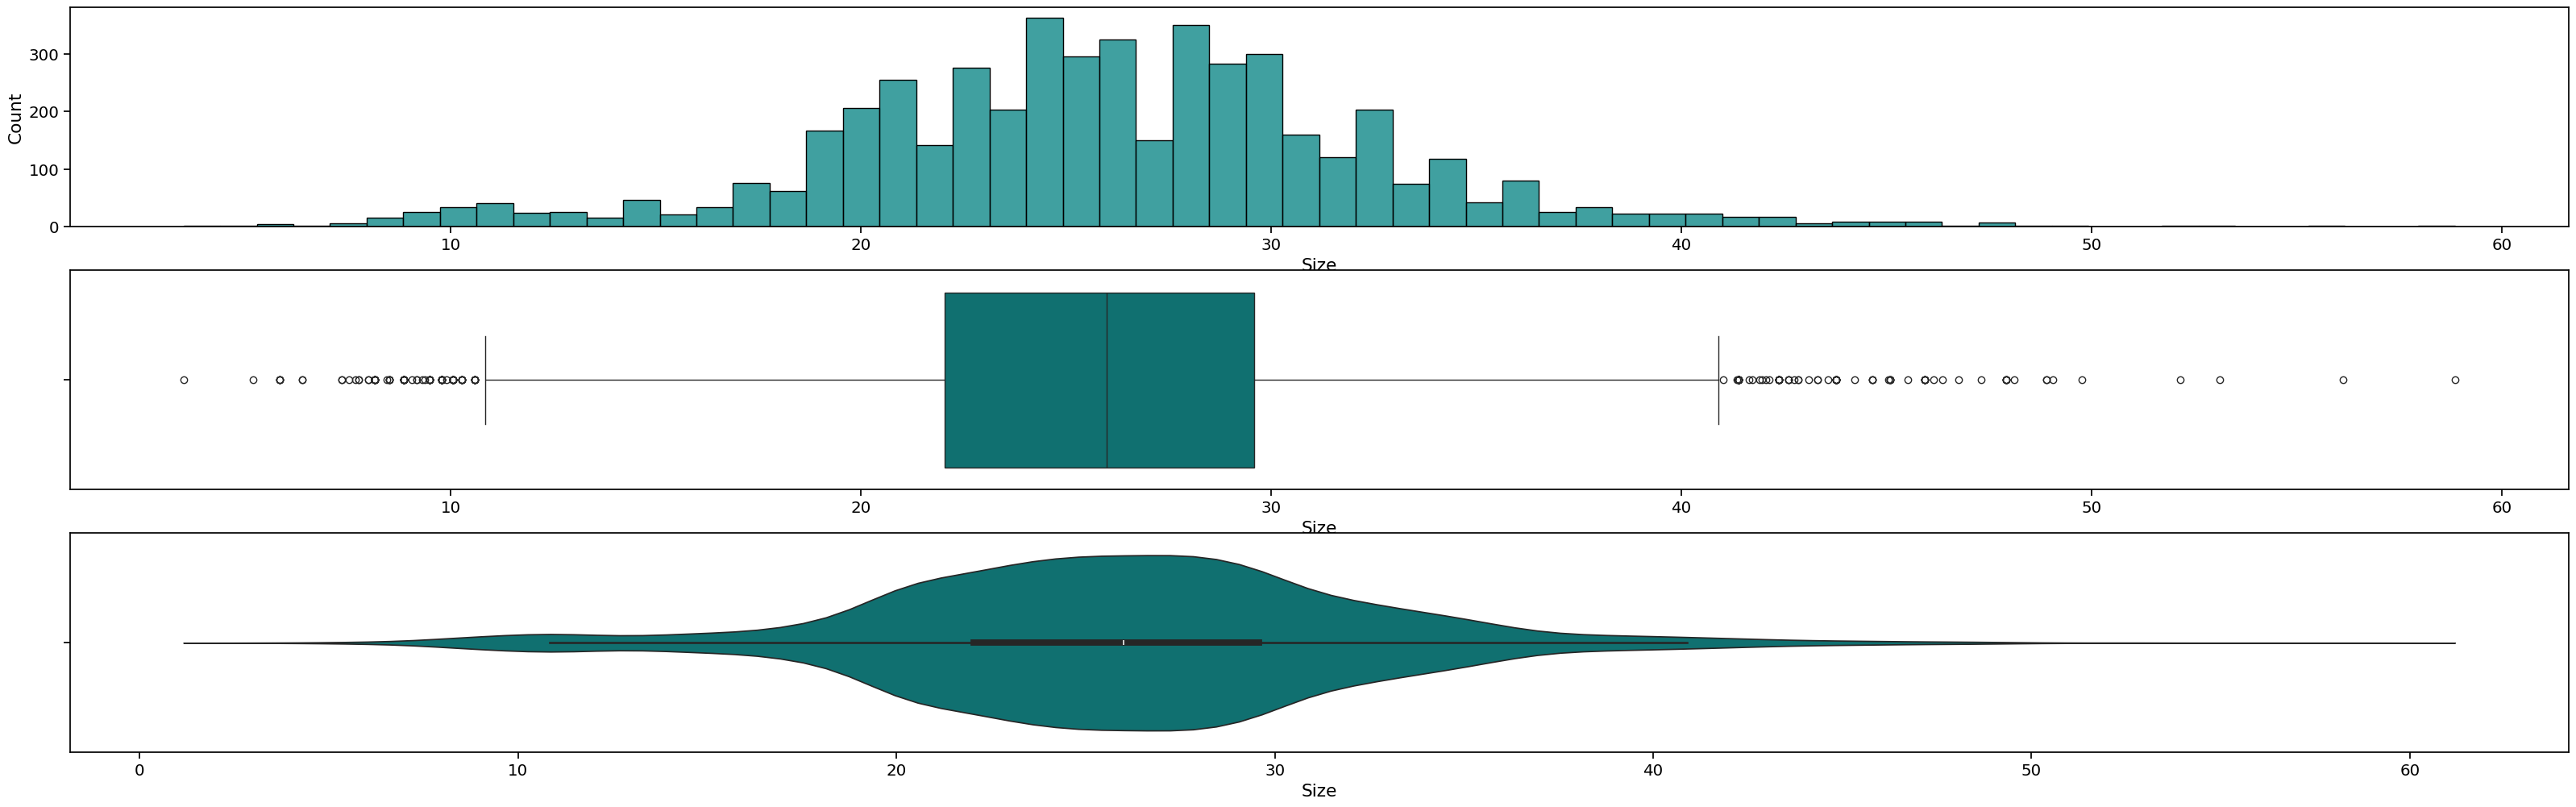

In [226]:
data['Size'] = boxcox(data['Size'])[0]

fig, ax = plt.subplots(3, 1, figsize=(40, 12))
ax1 = sns.histplot(x = data['Size'], color='teal', ax= ax[0])
ax2 = sns.boxplot(x = data['Size'], ax= ax[1], color= 'teal')
ax3 = sns.violinplot(x = data['Size'], ax= ax[2], color= 'teal')
plt.show()


In [227]:
dataset = pd.get_dummies(dataset, columns=['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact'], drop_first=False)

dataset.head()

,BHK,Rent,Size,Floor,Bathroom,Area Type_Built Area,Area Type_Carpet Area,Area Type_Super Area,City_Bangalore,City_Chennai,...,City_Mumbai,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,2,10000,1100,Ground out of 2,2,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,True
1,2,20000,800,1 out of 3,1,False,False,True,False,False,...,False,False,True,False,False,True,False,False,False,True
2,2,17000,1000,1 out of 3,1,False,False,True,False,False,...,False,False,True,False,False,True,False,False,False,True
3,2,10000,800,1 out of 2,1,False,False,True,False,False,...,False,False,False,True,False,True,False,False,False,True
4,2,7500,850,1 out of 2,1,False,True,False,False,False,...,False,False,False,True,True,False,False,False,False,True


### Engenharia de Requisitos

In [228]:
# Coluna Floor
dataset = dataset.join(dataset['Floor'].str.split(' out of ', n=1, expand=True).rename(columns={0:'Floor Level', 1:'Total Floors'}))
dataset['Floor Level'] = dataset.apply(lambda x: 0 if x['Floor Level'] =='Ground' \
                                 else ( -1 if x['Floor Level'] =='Lower Basement' else (x['Total Floors']) ) , axis=1)

dataset.drop('Floor', axis=1, inplace=True)
dataset = dataset.dropna()
dataset['Floor Level'] = dataset['Floor Level'].astype(int)
dataset['Total Floors'] = dataset['Total Floors'].astype(int)

dataset = dataset.drop_duplicates()

dataset.head()

,BHK,Rent,Size,Bathroom,Area Type_Built Area,Area Type_Carpet Area,Area Type_Super Area,City_Bangalore,City_Chennai,City_Delhi,...,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner,Floor Level,Total Floors
0,2,10000,1100,2,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,0,2
1,2,20000,800,1,False,False,True,False,False,False,...,True,False,False,True,False,False,False,True,3,3
2,2,17000,1000,1,False,False,True,False,False,False,...,True,False,False,True,False,False,False,True,3,3
3,2,10000,800,1,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,2,2
4,2,7500,850,1,False,True,False,False,False,False,...,False,True,True,False,False,False,False,True,2,2


### Modelagem

In [229]:
X = dataset.drop('Rent', axis= 1)
y = dataset['Rent']

y_boxcox, lambda_rent = boxcox(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size= 0.2, random_state = seed)

y_test_original = inv_boxcox(y_test, lambda_rent)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [230]:
X_train.shape

(3739, 23)

## Modelo

### KNN

In [231]:
# Treinando Modelo

knn_model = KNeighborsRegressor(n_neighbors = 4)
knn_model.fit(X_train, y_train)

knn_pred = knn_model.predict(X_test)
knn_pred_original = inv_boxcox(knn_pred, lambda_rent)

In [232]:
#  Avaliação do Modelo

kf = KFold(n_splits= 10)
knn_rmse_result = np.mean(np.sqrt(-cross_val_score(knn_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
knn_mae_result = mean_absolute_error(y_test, knn_pred)
knn_r2_result = r2_score(y_test, knn_pred)

print(f'RMSE {knn_rmse_result:.4f}')
print(f'MAE: {knn_mae_result:.4f}')
print(f'R2: {knn_r2_result:.4f}')

RMSE 0.0155
MAE: 0.0112
R2: 0.7389


### Naive Bayes

In [233]:
# Treinando Modelo

nb_model = BayesianRidge()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_pred_original = inv_boxcox(nb_pred, lambda_rent)

In [234]:
#  Avalicação do Modelo

kf = KFold(n_splits= 10)
nb_rmse_result = np.mean(np.sqrt(-cross_val_score(nb_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
nb_mae_result = mean_absolute_error(y_test, nb_pred)
nb_r2_result = r2_score(y_test, nb_pred)

print(f'RMSE {nb_rmse_result:.4f}')
print(f'MAE: {nb_mae_result:.4f}')
print(f'R2: {nb_r2_result:.4f}')

RMSE 0.0148
MAE: 0.0108
R2: 0.7659


### Regressão Linear

In [249]:
# Treinando Modelo

lnrg_model = keras.Sequential([
    keras.layers.Dense(1)
])

lnrg_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')

lnrg_model_history=lnrg_model.fit(X_train, y_train, epochs=30, validation_split = 0.1)
lnrg_pred=lnrg_model.predict(X_test)

Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7948 - val_loss: 2.6924
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6853 - val_loss: 2.5861
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5780 - val_loss: 2.4804
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4708 - val_loss: 2.3752
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3638 - val_loss: 2.2700
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2569 - val_loss: 2.1648
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1504 - val_loss: 2.0606
Epoch 8/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0443 - val_loss: 1.9569
Epoch 9/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9386 - val_loss: 1.8537
Epoch 10/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8335 - val_loss: 1.7508
Epoch 11/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7283 - val_loss: 1.6481
Epoch 12/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

RMSE 0.0149
MAE: 0.0114
R2: 0.7417


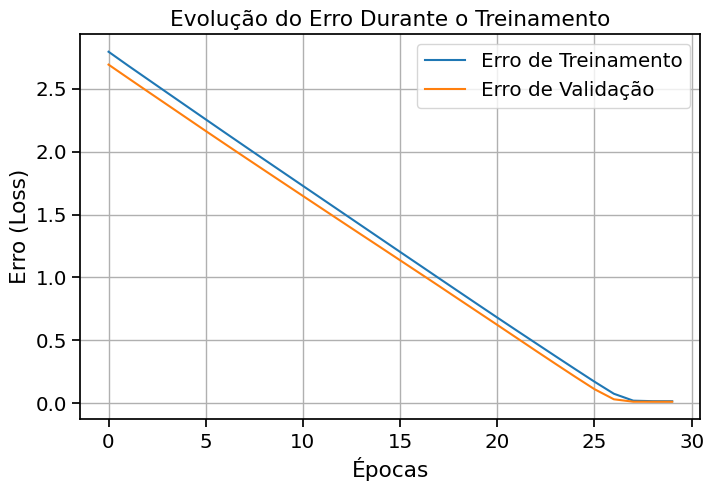

In [255]:
#  Avaliação do Modelo

kf = KFold(n_splits= 10)
lnrg_mae_result = mean_absolute_error(y_test, lnrg_pred)
lnrg_rmse_result = math.sqrt(mean_squared_error(y_test, lnrg_pred))
lnrg_r2_result = r2_score(y_test, lnrg_pred)

print(f'RMSE {lnrg_rmse_result:.4f}')
print(f'MAE: {lnrg_mae_result:.4f}')
print(f'R2: {lnrg_r2_result:.4f}')

# Plot epochs
df_history = pd.DataFrame(lnrg_model_history.history)
plt.figure(figsize=(8,5))
plt.plot(df_history['loss'], label='Erro de Treinamento')
plt.plot(df_history['val_loss'], label='Erro de Validação')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.title('Evolução do Erro Durante o Treinamento')
plt.legend()
plt.grid(True)
plt.show()

### Árvore de Decisões

In [237]:
# Treinando Modelo
dt_model = DecisionTreeRegressor(
    criterion='squared_error',  
    max_depth=5,       
    random_state=seed
)

dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)

RMSE 0.0158
MAE: 0.0113
R2: 0.7474


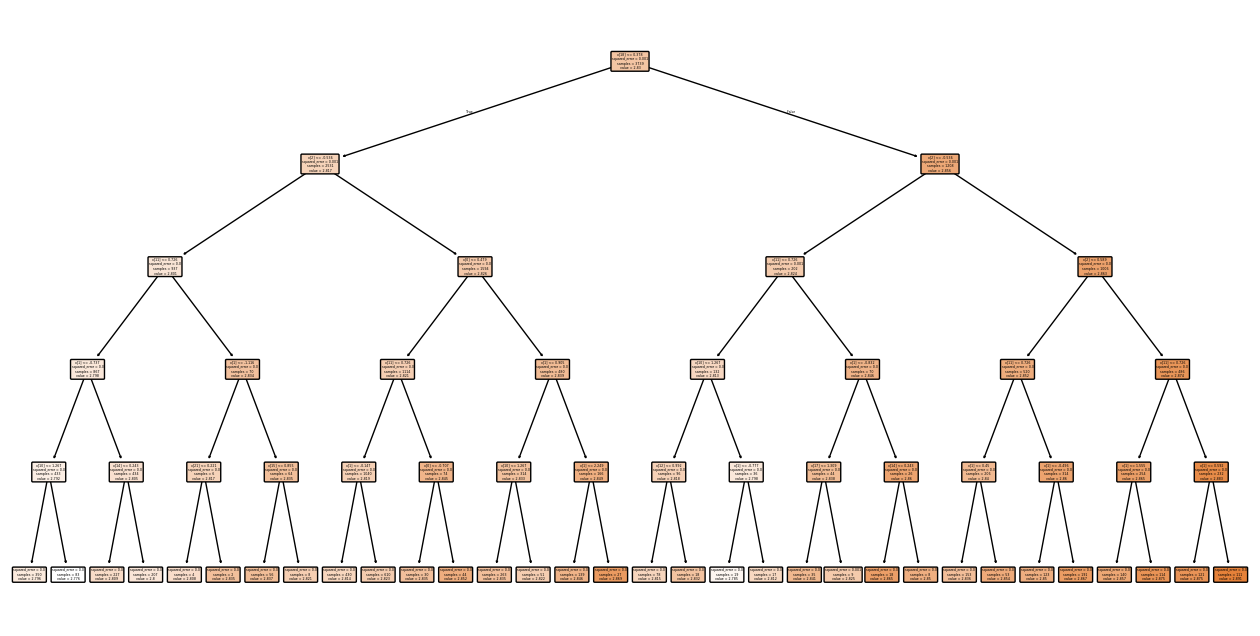

In [238]:
#  Avaliação do Modelo

kf = KFold(n_splits= 10)
dt_rmse_result = np.mean(np.sqrt(-cross_val_score(dt_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
dt_mae_result = mean_absolute_error(y_test, dt_pred)
dt_r2_result = r2_score(y_test, dt_pred)

print(f'RMSE {dt_rmse_result:.4f}')
print(f'MAE: {dt_mae_result:.4f}')
print(f'R2: {dt_r2_result:.4f}')

plt.figure(figsize=(16,8))
plot_tree(dt_model, filled=True, rounded=True)
plt.show()

### Redes Neurais

In [239]:
# Treinando Modelo

class R2History(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.r2 = []
        self.val_r2 = []

    def on_epoch_end(self, epoch, logs=None):
        y_tr_pred = self.model.predict(X_train, verbose=0)
        y_val_pred = self.model.predict(X_test, verbose=0)

        r2_tr = r2_score(y_train, y_tr_pred)
        r2_v = r2_score(y_test, y_val_pred)

        self.r2.append(r2_tr)
        self.val_r2.append(r2_v)

rdnr_model = keras.Sequential([
    layers.Dense(23, activation='relu'),
    layers.Dense(15, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1),
])

rdnr_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                   loss='mean_absolute_error')
r2_cb = R2History()

rdnr_model_history = rdnr_model.fit(
    X_train, y_train,
    epochs=500,      
    validation_split=0.2,
    batch_size=16,
    verbose=0,
    callbacks=[r2_cb]
)

rdnr_pred=rdnr_model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


RMSE: 0.0154
MAE: 0.0118
R2: 0.7238


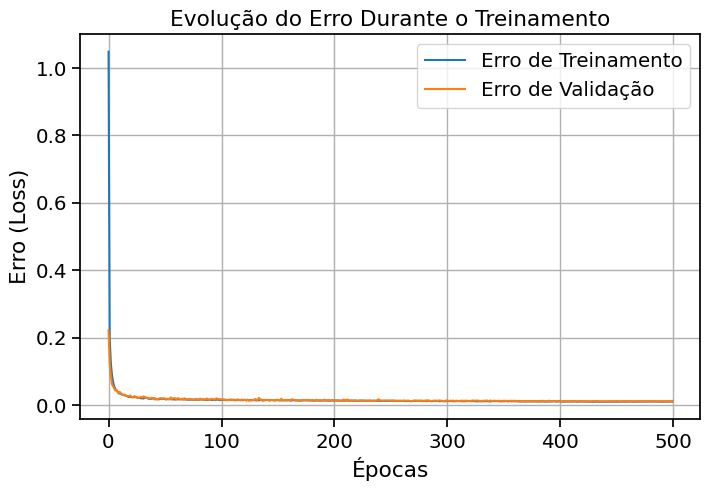

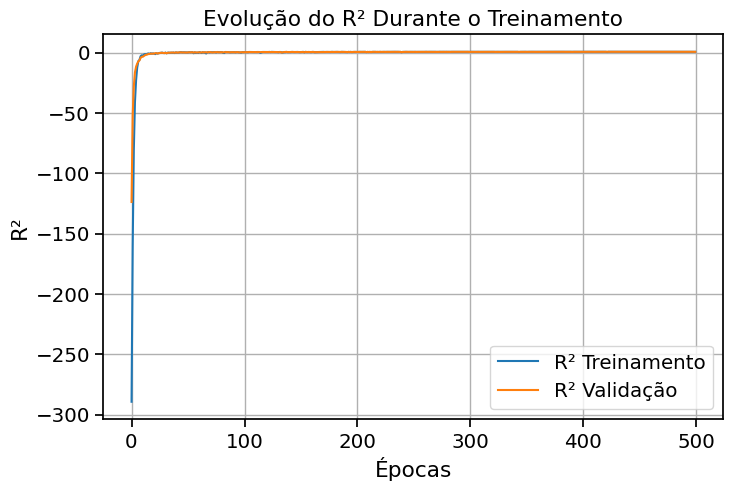

In [240]:
#  Avaliação do Modelo

test_loss = rdnr_model.evaluate(X_test, y_test, verbose=0)
rdnr_rmse_result = np.sqrt(mean_squared_error(y_test, rdnr_pred))
rdnr_mae_result = mean_absolute_error(y_test, rdnr_pred)
rdnr_r2_result = r2_score(y_test, rdnr_pred)

print(f'RMSE: {rdnr_rmse_result:.4f}')
print(f'MAE: {rdnr_mae_result:.4f}')
print(f'R2: {rdnr_r2_result:.4f}')

# Plot epochs
df_history = pd.DataFrame(rdnr_model_history.history)
plt.figure(figsize=(8,5))
plt.plot(df_history['loss'], label='Erro de Treinamento')
plt.plot(df_history['val_loss'], label='Erro de Validação')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.title('Evolução do Erro Durante o Treinamento')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(r2_cb.r2, label='R² Treinamento')
plt.plot(r2_cb.val_r2, label='R² Validação')
plt.xlabel('Épocas')
plt.ylabel('R²')
plt.title('Evolução do R² Durante o Treinamento')
plt.legend()
plt.grid(True)
plt.show()

In [241]:
# Treinando Modelo

class R2History(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.r2 = []
        self.val_r2 = []

    def on_epoch_end(self, epoch, logs=None):
        y_tr_pred = self.model.predict(X_train, verbose=0)
        y_val_pred = self.model.predict(X_test, verbose=0)

        r2_tr = r2_score(y_train, y_tr_pred)
        r2_v = r2_score(y_test, y_val_pred)

        self.r2.append(r2_tr)
        self.val_r2.append(r2_v)

rdnr_model = keras.Sequential([
    layers.Dense(23, activation='relu'),
    layers.Dense(15, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1),
])

rdnr_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                   loss='mean_absolute_error')
r2_cb = R2History()

rdnr_model_history = rdnr_model.fit(
    X_train, y_train,
    epochs=500,      
    validation_split=0.2,
    batch_size=16,
    verbose=0,
    callbacks=[r2_cb]
)

rdnr_pred=rdnr_model.predict(X_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


RMSE: 0.0150
MAE: 0.0110
R2: 0.7379


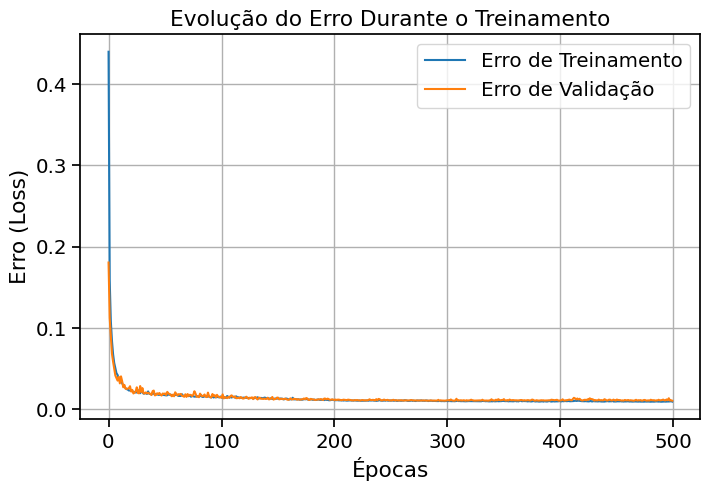

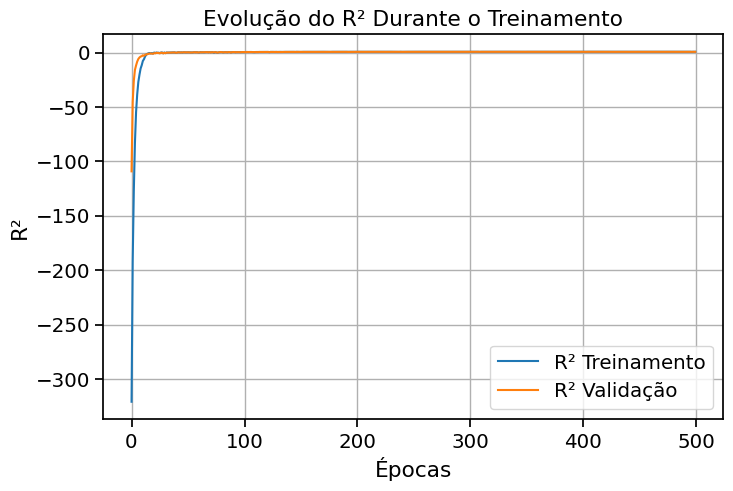

In [242]:
#  Avaliação do Modelo

test_loss = rdnr_model.evaluate(X_test, y_test, verbose=0)
rdnr_rmse_result = np.sqrt(mean_squared_error(y_test, rdnr_pred))
rdnr_mae_result = mean_absolute_error(y_test, rdnr_pred)
rdnr_r2_result = r2_score(y_test, rdnr_pred)

print(f'RMSE: {rdnr_rmse_result:.4f}')
print(f'MAE: {rdnr_mae_result:.4f}')
print(f'R2: {rdnr_r2_result:.4f}')

# Plot epochs
df_history = pd.DataFrame(rdnr_model_history.history)
plt.figure(figsize=(8,5))
plt.plot(df_history['loss'], label='Erro de Treinamento')
plt.plot(df_history['val_loss'], label='Erro de Validação')
plt.xlabel('Épocas')
plt.ylabel('Erro (Loss)')
plt.title('Evolução do Erro Durante o Treinamento')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(r2_cb.r2, label='R² Treinamento')
plt.plot(r2_cb.val_r2, label='R² Validação')
plt.xlabel('Épocas')
plt.ylabel('R²')
plt.title('Evolução do R² Durante o Treinamento')
plt.legend()
plt.grid(True)
plt.show()

### Resultado

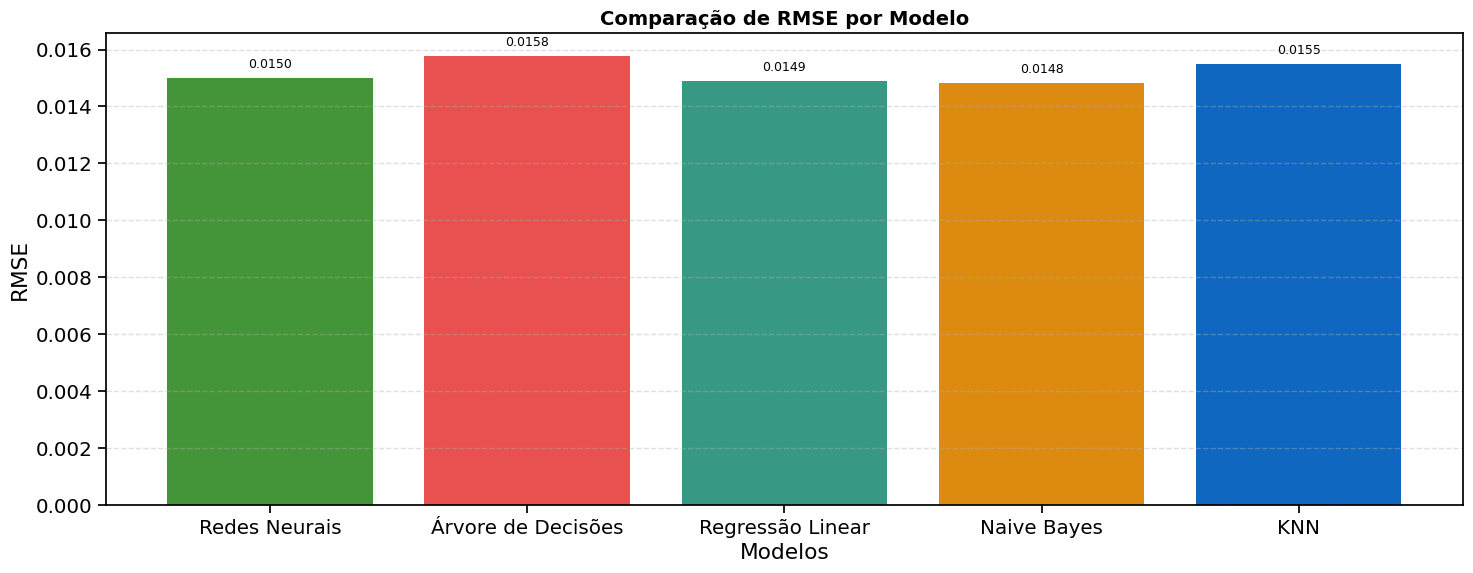

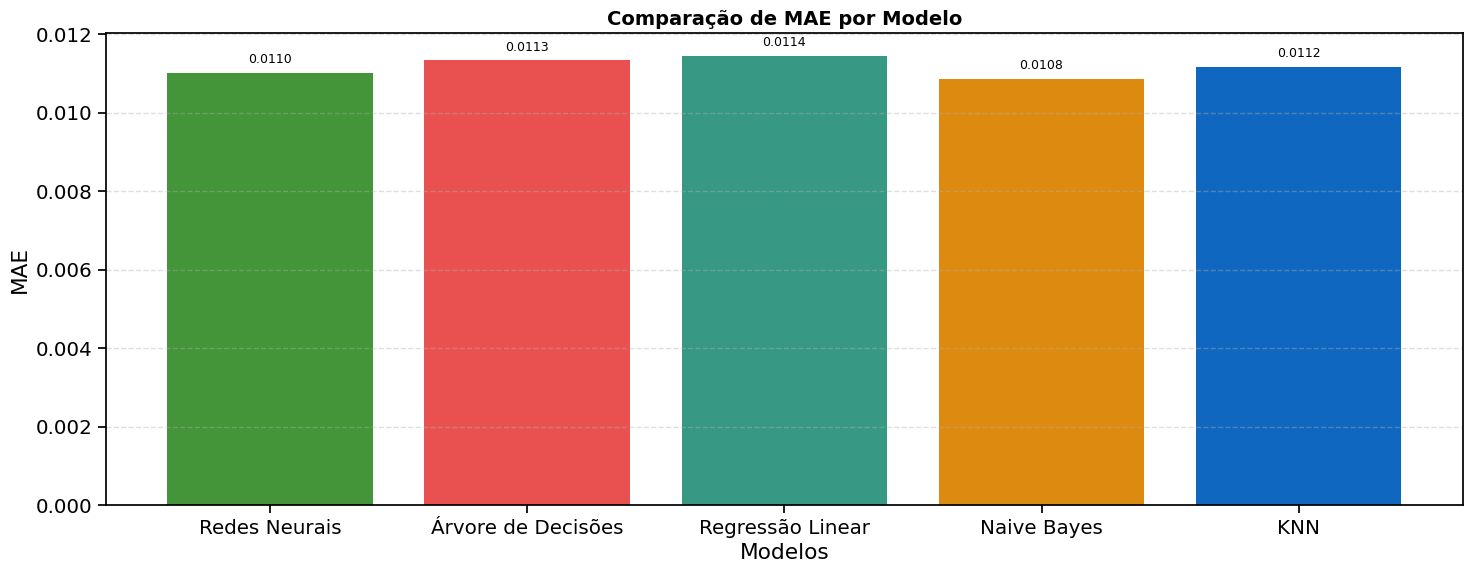

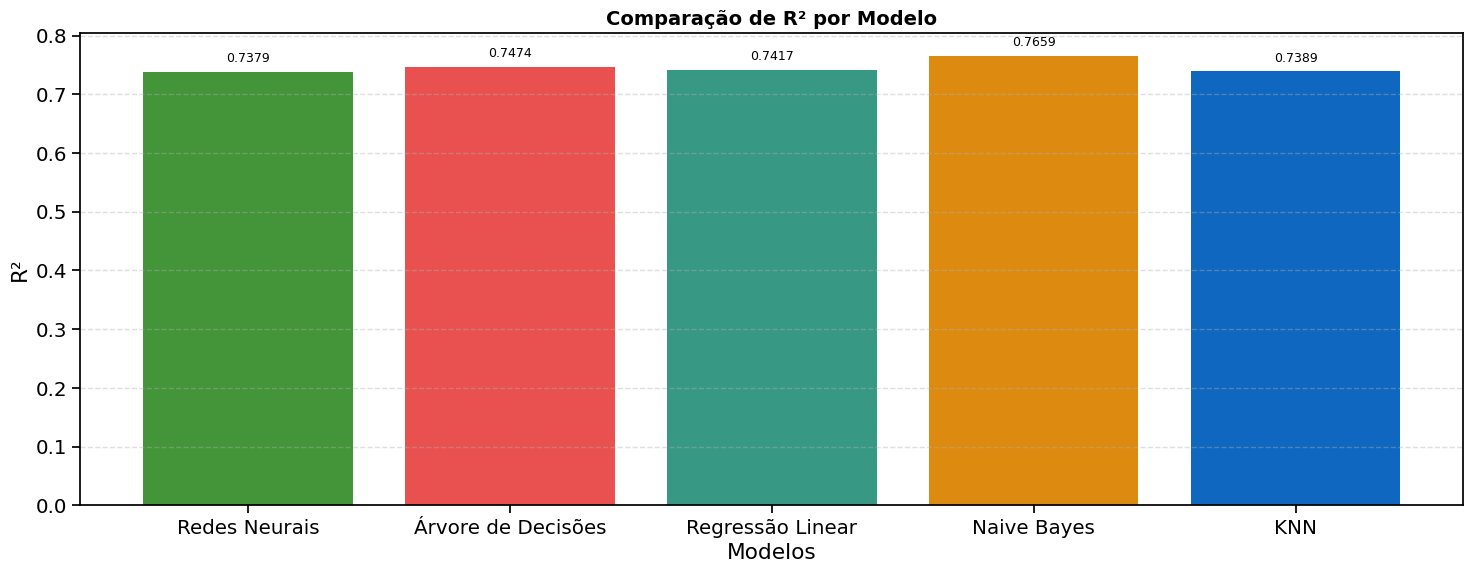

In [262]:
# Comparação dos Modelos

models = ['Redes Neurais', 'Árvore de Decisões', 'Regressão Linear', 'Naive Bayes', 'KNN']

rmse_vals = [
    rdnr_rmse_result,
    dt_rmse_result,
    lnrg_rmse_result,
    nb_rmse_result,
    knn_rmse_result
]

mae_vals = [
    rdnr_mae_result,
    dt_mae_result,
    lnrg_mae_result,
    nb_mae_result,
    knn_mae_result
]

r2_vals = [
    rdnr_r2_result,
    dt_r2_result,
    lnrg_r2_result,
    nb_r2_result,
    knn_r2_result
]

def plot_metric(models, values, title, ylabel):
    colors = ["#449439", "#E95151", "#379984", "#DD8B10", "#0F67C0"] 

    fig, ax = plt.subplots(figsize=(15, 6))
    bars = ax.bar(models, values, color=colors)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Modelos')
    ax.set_ylabel(ylabel)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.4f}', 
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# --- Gráficos individuais ---
plot_metric(models, rmse_vals, 'Comparação de RMSE por Modelo', 'RMSE')
plot_metric(models, mae_vals, 'Comparação de MAE por Modelo', 'MAE')
plot_metric(models, r2_vals, 'Comparação de R² por Modelo', 'R²')